In [1]:
from datetime import datetime, timedelta
import numpy as np
import time
import uuid

- maximum 200 puffs per day per user
- events dating to the last 90 days
- multiple users
- multiple types of events

In [2]:
# ensure for reproducibility
np.random.seed(42)

In [3]:
def get_event_time():
    hour =  np.random.randint(24)
    minute = np.random.randint(60)
    second = np.random.randint(60)
    return hour, minute, second

In [4]:
def get_events_time_for_date(d):
    datetimes = []
    n_puffs = np.random.randint(50, 200)
    for _ in range(n_puffs):
        
        hour, minute, second = get_event_time()
        puff_time = datetime(d.year, d.month, d.day, hour, minute, second)
        datetimes.append(puff_time)
    return datetimes

In [5]:
event_types = ["puffTakenEvent", "deviceConnectedEvent", "deviceDisconnectedEvent"]

In [6]:
y = datetime.now().year
m = datetime.now().month
d = datetime.now().day
today_date = datetime(y, m, d)

In [7]:
user_ids = [str(uuid.uuid4()) for _ in range(5)]
user_ids

['47dfcad6-d29f-48da-a303-1f128f68f128',
 '93594229-bd4f-4cfa-8a30-97ea3facc59c',
 '6657a8d9-3fcf-438e-a754-b6fb6f6263c1',
 '83903911-d6bb-4935-bee6-c9dc46c52196',
 '0443b728-a687-495b-9a74-1107d4122d3d']

In [8]:
now = datetime.now()

In [9]:
now

datetime.datetime(2021, 4, 16, 16, 41, 40, 646146)

In [10]:
def to_timestamp(date_time):
    return time.mktime(date_time.timetuple())

In [11]:
ts = to_timestamp(now)
ts

1618584100.0

In [12]:
datetime.fromtimestamp(ts)

datetime.datetime(2021, 4, 16, 16, 41, 40)

In [13]:
# generate events
events = []

for user_id in user_ids:
    for d in range(90):
        cur_date = (today_date - timedelta(days=d)).date()
        event_times = get_events_time_for_date(cur_date)
        
        for event_time in event_times:
            event_type = np.random.choice(event_types, size=1, p=[0.9, 0.05, 0.05])[0]
            timestamp = to_timestamp(event_time)
            events.append(
                (user_id, event_type, timestamp)
            )

In [14]:
len(events)

54978

In [15]:
events[0]

('47dfcad6-d29f-48da-a303-1f128f68f128', 'puffTakenEvent', 1618594094.0)

In [16]:
events = sorted(events, key=lambda x: x[-1], reverse=False)

In [17]:
events[0], events[-1]

(('93594229-bd4f-4cfa-8a30-97ea3facc59c', 'puffTakenEvent', 1610838023.0),
 ('0443b728-a687-495b-9a74-1107d4122d3d', 'puffTakenEvent', 1618610369.0))

In [18]:
# we expect the first and the last event to have approx. 90 days difference
(events[-1][2] - events[0][2]) / (60*60*24)

89.95770833333333

In [19]:
import pandas as pd

In [20]:
df = pd.DataFrame(events, columns=['user_id', 'event_type', 'timestamp'])

In [21]:
df.groupby('event_type').size()

event_type
deviceConnectedEvent        2772
deviceDisconnectedEvent     2743
puffTakenEvent             49463
dtype: int64

In [22]:
df.timestamp.min() == df.timestamp.iloc[0]

True

In [23]:
df.timestamp.max() == df.timestamp.iloc[-1]

True

In [24]:
df.iloc[0].timestamp

1610838023.0

In [25]:
df.iloc[1].timestamp

1610838092.0

In [26]:
def to_date(t):
    dt = datetime.fromtimestamp(t)
    return dt.strftime("%Y-%m-%d")

In [27]:
df['date_time'] = df.timestamp.apply(lambda t: to_date(t))

In [28]:
df_freq = df.groupby(['user_id', 'date_time']).size().reset_index(name='freq')

In [29]:
sample = df_freq[df_freq.user_id == user_ids[0]].reset_index(drop=True)

In [30]:
sample.head()

,user_id,date_time,freq
0,47dfcad6-d29f-48da-a303-1f128f68f128,2021-01-17,172
1,47dfcad6-d29f-48da-a303-1f128f68f128,2021-01-18,131
2,47dfcad6-d29f-48da-a303-1f128f68f128,2021-01-19,182
3,47dfcad6-d29f-48da-a303-1f128f68f128,2021-01-20,118
4,47dfcad6-d29f-48da-a303-1f128f68f128,2021-01-21,146


In [31]:
sample.date_time.describe()

count             90
unique            90
top       2021-02-27
freq               1
Name: date_time, dtype: object

In [32]:
np.min(sample.freq), np.max(sample.freq)

(50, 198)

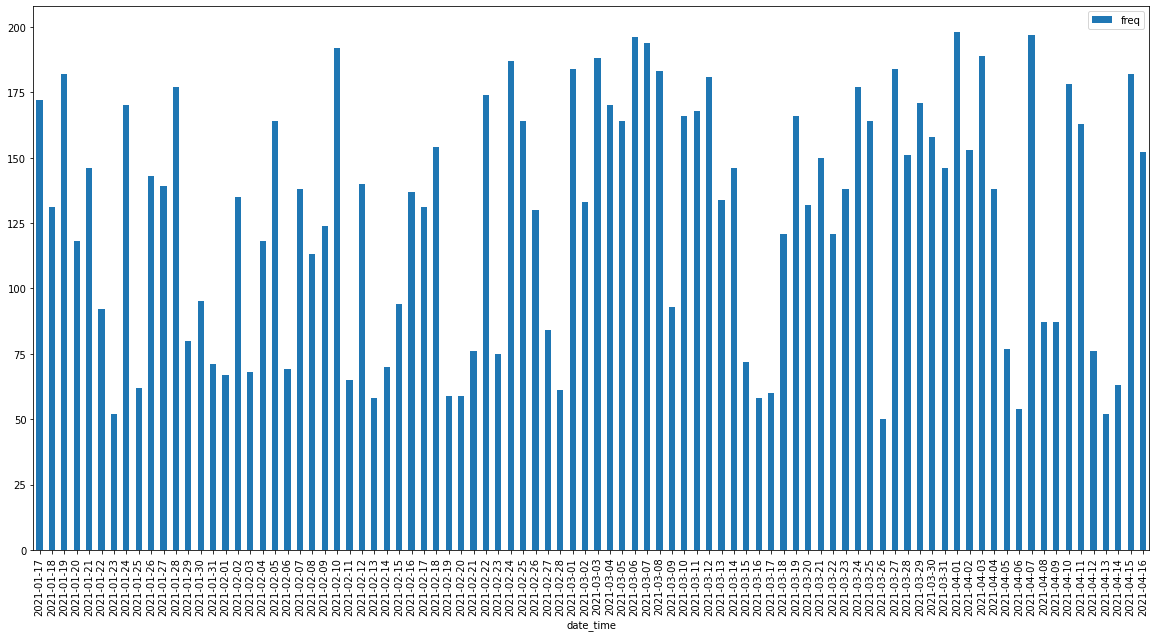

In [33]:
sample.plot(kind='bar',figsize=(20,10), x='date_time', y='freq');

In [34]:
import json

In [35]:
with open("test_events.jsonl", "w") as f:
    json_objects = [json.dumps({"eventType": row.event_type, "userId": row.user_id, "timestamp": row.timestamp}) for index, row in df.iterrows()]
    f.write("\n".join(json_objects))